# Sistemas Dinamicos y EDOs

## 1. Introduccion


In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [3]:
import time

import logging

import statistics

from typing import Optional, List

In [4]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import Dataset

In [5]:
import torchdiffeq

In [6]:
import rich

In [7]:
import pytorch_lightning as pl
from torchmetrics.classification import Accuracy
pl.seed_everything(42)

Global seed set to 42


42

In [8]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Discpositivo: {device}")

Discpositivo: cuda


### Sistemas Dinamicos

Un **sistema dinamico** es una tripleta $$(\mathcal{S}, \mathcal{T}, \Phi)$$ donde
- $\mathcal{S}$ es el *espacio de estados*
- $\mathcal{T}$ es el *espacio de parametros*,y
- $\Phi: (\mathcal{T} \times \mathcal{S}) \longrightarrow \mathcal{S}$ es la evolucion.

Observacion: En este trabajo usaremos EDOs donde $\Phi$ sera una *general solution*: en efecto una familia uniparametroca de transformaciones del espacio de estados. $\mathcal{T}=\mathbb{R}_{+}$ es el tiempo, y usualmente, $\mathcal{S}=\mathbb{R}^{n}$ es el espacio de estados. La evolucion toma un punto en el espacio, un punto en el tiempo, y retorna un punto en el espacio. Este es el concepto de *flujo*. 

## 1. Ecuaciones Diferenciales

Trabajaremos con *problemas de valor inicial* (IVP, PVI) definidos por una EDO de primer orden, y un valor inicial:

$$\dot{y} = f(y, t), \quad y(t_{0}) = y_{0},$$

donde usaremos la notacion acortada $\dot{y} := \frac{\mathrm{d}y}{\mathrm{d}t}$.

Una solucion general de una EDO es una funcion $y: I \times \mathbb{R}^{n} ⟶ \mathbb{R}^{n}$: una familia uniparametrica de transformaciones del espacio de estado (usualmente el parametro es el tiempo). La existencia y unicidad de soluciones de un PVI se asegura con el teorema de  Picard-Lindel&ouml;f, provista que el lado derecho de la EDO sea *Lipschitz continua*.

### Metodo de Euler

Resolver muchas EDOs analiticamente es complejo, por lo que usualmente las resolvemos mediante aproximaciones numericas. Metodos como
Runge-Kutta son una familia de metodos iterativos que aproximan la solucion de PVIs. El metodo mas simple de este es el denominado metodo de **Euler**.

Consideremos el PVI

$$\dot{y} = f(y, t), \quad y(t_{0}) = y_{0}.$$

donde $y(t_0)$, y $f$ estan dados.

Escojamos un tamano de paso $h>0$, un numero de pasos $N$, y definamos

$$
\begin{aligned}
&y_{n+1} = y_{n} + hf(y_{n}, t_{n}) \\
&t_{n+1} = t_{n} + h.
\end{aligned}
$$

Este es el integrador numerico mas basico. La intuiciion detras del metodo de Euler es que estamos evolucionando las trayectorias iterativamente pues estamos tomando pequenos pasos en la direccion de la pendiente.

### Metodo Runge-Kutta

El metodo de Euler, como ya mencionamos antes, es el mas simple dentro de la familia de metodos conocidos como Runge-Kutta methods. Describiremos el metodo RK4.

Consideremos el mismo PVI que arriba. Nuevameente, escojamos un tamano de paso $h>0$, un numero de paso $N$, y definamos

$$
\begin{aligned}
&y_{n+1} = y_{n} + \frac{1}{6}h(k_{1} + 2k_{2} + 2k_{3} + k_{4}) \\
&t_{n+1} = t_{n} + h
\end{aligned}
$$

para $n=0, 1, 2, 3, \dots, N$ con

$$
\begin{aligned}
&k_{1} = f\left(y_{n}, t_{n}\right) \\
&k_{2} = f\left(y_{n} + h\frac{k_{1}}{2}, t_{n} + \frac{h}{2}\right) \\
&k_{3} = f\left(y_{n} + h\frac{k_{2}}{2}, t_{n} + \frac{h}{2}\right) \\
&k_{4} = f\left(y_{n} + hk_{3}, t_{n} + h\right).
\end{aligned}
$$ 

Obs: Es facil ver que Euler corresponde a considerar solo $k_1$ de RK4B.

#### Intuition

Aquí damos una explicación intuitiva de por qué este método aproxima las soluciones a los IVP. Al igual que con el método de Euler, utilizaremos la expansión de Taylor de la solución.

Sea $y(t)$ la solucion. Escribamos la expansión de Taylor de $y(t)$ en la vecindad de $t_n$ al término $h^{2}$:

$$
y(t_{n+1}) = y(t_n) + h \frac{dy}{dt}\Big|_{t_n} + \frac{h^2}{2} \frac{d^{2}y}{dt^{2}}\Big|_{t_n} + O\big(h^3\big).
$$

sabemos que $\frac{dy}{dt}\big|_{t_n} = f(y_n, t_n)$ y por tanto

$$
\frac{d^{2}y}{dt^{2}}\Big|_{t_n} = \frac{df(y, t)}{dt}\Big|_{t_n} = \frac{\partial f}{\partial t}\Big|_{t_n} + f \frac{\partial f}{\partial y}\Big|_{t_n},
$$

donde usamos la regla de la cadena. La expancion de Taylor se transforma en

$$
y(t_{n+1}) = y(t_n) + h f(y_n, t_n) + \frac{h^2}{2} \left[\frac{\partial f}{\partial t}\Big|_{t_n} + f \frac{\partial f}{\partial y}\Big|_{t_n}\right] + O\big(h^3\big).
$$

Si observamos $k_2$, Taylor puede expandirlo correctamente a $O\big(h^{3}\big)$ como

$$
k_2 = f(y_{n} + \beta k_{1}, t_{n} + \alpha h) = h \left( f(y_n, t_n) + \alpha h \frac{\partial f}{\partial t}\Big|_{t_n} + \beta f \frac{\partial f}{\partial y}\Big|_{t_n} \right) + O\big(h^3\big),
$$

que es precisamente el tercer término en la expansión de Taylor de $y(t_n)$. Comparando con la ecuación anterior encontramos condiciones en $\alpha$ y $\beta$. Tenga en cuenta que el valor de estos coeficientes depende del orden en el que decidamos detenernos.
Los coeficientes de orden superior se pueden calcular de la misma manera.

#### Aproximacion de errores

Este método se llama *Runge-Kutta Clasico* o *RK4*. Este es un método de cuarto orden, lo que significa que el *error de truncamiento local* es del orden $O\big(h^{5}\big)$, y el *error de truncamiento total* es del orden $O\big(h^{4}\big)$. El truncamiento local y los errores de acumulación total se definen de la siguiente manera:

Para un método de integración de un paso, como RK4, de forma

$$
y_{n+1} = y_{n} + hA(y_{n}, t_{n}, h, f),
$$

el *error de truncamiento local* en el tiempo $t_{n+1}$, $\tau_{n+1}$ es

$$
\tau_{n+1} = y(t_{n+1}) - y(t_{n}) - hA(y_{n}, t_{n}, h, f).
$$

El *error de truncamiento total* en el tiempo $t_{n+1}$, $e_{n+1}$ es

$$
e_{n+1} = y(t_{n+1}) - ( y_{0} + hA(y_{0}, t_{0}, h, f) + \dots + hA(y_{n}, t_{n}, h, f)).
$$

#### Ejemplo: ecuaciones de Lotka-Volterra
Consideremos  el PVI

$$
\begin{aligned}
\dot{x} = x - xy \\
\dot{y} = xy - y,
\end{aligned}
$$

con valores iniciales $(x_{0}, y_{0}) = (1, 2)$. No existe una solución de forma cerrada para este sistema de EDOs. Comparamos los rendimientos de RK4 y Euler simple para diferentes valores de tamaño de paso $h$.

In [9]:
def LV(x, y):
  return np.array([x - x*y, x*y - y])

def rk4(f, x0, y0, h, n):
    
    v = [0]*(n+1)
    v[0] = np.array([x0, y0])
    x = x0 
    y = y0
    for i in range(1, n + 1):
        k1 = h*f(x, y)
        k2 = h*f(x + 0.5*k1[0], y + 0.5*k1[1])
        k3 = h*f(x + 0.5*k2[0], y + 0.5*k2[1])
        k4 = h*f(x + k3[0], y + k3[1])
        v[i] =  v[i-1] + (k1 + k2 + k2 + k3 + k3 + k4)/6
        x = v[i][0]
        y = v[i][1]

    t = np.array([i*h for i in range(0, n+1)])
    return t, np.array(v)

def euler(f, x0, y0, h, n):

    v = [0]*(n+1)
    v[0] = np.array([x0, y0])
    x = x0 
    y = y0

    for i in range(1, n + 1):
        v[i] =  v[i-1] + h*f(x, y)
        x = v[i][0]
        y = v[i][1]

    t = np.array([i*h for i in range(0, n+1)])
    return t, np.array(v)

def plot_integrator(v_euler, v_rk4, t_euler, t_rk4, v_true, t_true, h):

    fig = plt.figure(figsize=(18,8))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)

    ax0.plot(t_euler, v_euler, marker = 'x')
    ax1.plot(t_rk4, v_rk4, marker = 'x')
    
    ax0.plot(t_true, v_true)
    ax1.plot(t_true, v_true)

    ax0.set_ylim(0, 3.5)
    ax1.set_ylim(0, 3.5)

    ax0.set_xlabel(r"t", fontsize=25)
    ax0.set_title("Euler, $h=$"+h, fontsize=25)
    ax0.legend(["x Euler", "y Euler", "x T", "y T"])
    ax1.set_xlabel(r"$t$", fontsize=25)
    ax1.set_title("RK4, $h=$"+h, fontsize=25)
    ax1.legend(["x RK4", "y RK4", "x T", "y T"])

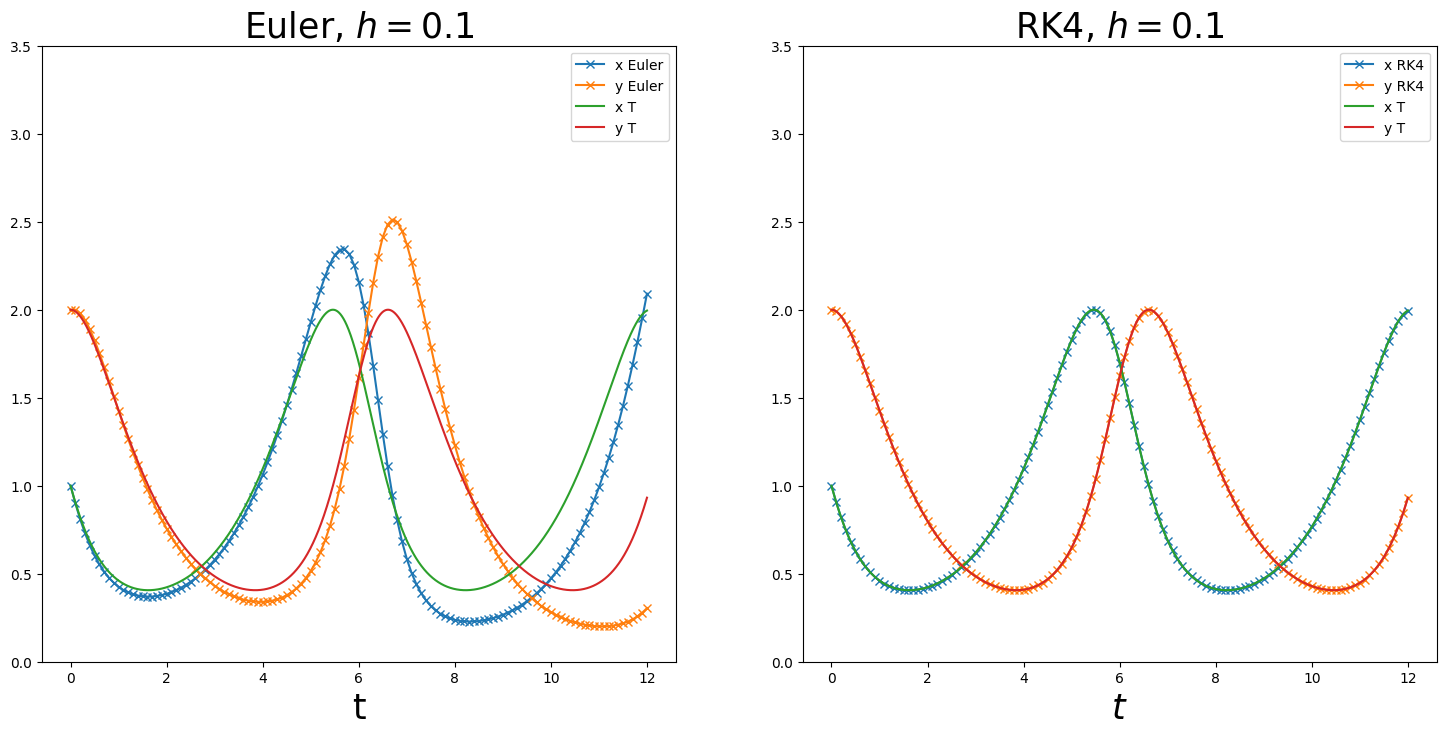

In [10]:
h = 0.1

t_euler, v_euler = euler(LV, 1., 2., h, 120)
t_rk4, v_rk4 = rk4(LV, 1., 2., h, 120)
t_true, v_true = rk4(LV, 1., 2., 0.003, 4000)

plot_integrator(v_euler, v_rk4, t_euler, t_rk4, v_true, t_true, str(h))

### Espacio de fase y phase portrait

Es útil introducir el concepto de espacio de fase y retrato de fase (phase portrait). Consideremos la ecuación diferencial del péndulo simple de masa 1, longitud 1 y $g$ puesta a 1 por conveniencia:

$$
\ddot{\theta} + \sin{\theta} = 0.
$$

Esta es una EDO de segundo orden, pero se puede transformar en el siguiente sistema equivalente de EDO de primer orden introduciendo la variable auxiliar $p_{\theta} = \dot{\theta}$:

$$
\begin{align}
&\dot{\theta} = p_{\theta} \\
&\dot{p_{\theta}} = \sin(\theta).
\end{align}
$$

$S^{1}\times\mathbb{R}$ es llamado *espacio de fase*, y $(\theta, p_{\theta}) \in S^{1}\times\mathbb{R}$ son llamados *variables de espacio de fase* ($\theta$ es periodica y por tanto vive en $S^{1} = \{x \mod 2\pi | x \in \mathbb{R}\}$).

Dada una solucion $(\theta(t), p_{\theta}(t))$ podemos representarla como un camino en el espacio de fase $S^{1}\times\mathbb{R}$.

In [11]:
def pendulum(x, y):
  return np.array([y, -np.sin(x)])

def plot_phase_space(v):

    fig = plt.figure(figsize=(10,6))
    ax0 = fig.add_subplot(111)

    ax0.plot([p[0] for p in v], [p[1] for p in v])
  
    ax0.set_xlabel(r"$\theta$", fontsize=25)
    ax0.set_ylabel(r"$p_{\theta}$", fontsize=25)
    ax0.set_title("Espacio de fase", fontsize=25)
    ax0.set_aspect('equal')

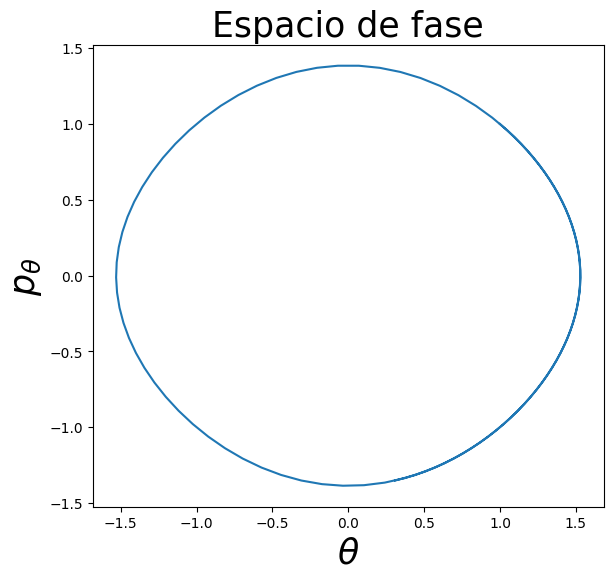

In [12]:
t_pendulum, v_pendulum = rk4(pendulum, 1., 1., 0.1, 100)
plot_phase_space(v_pendulum)

Una colección de caminos en el espacio de fase se llama *retrato de espacio de fase* (o diagrama de espacio de fase, o a veces diagrama de espacio de estado), que puede pensarse como una representación geométrica de las trayectorias (aquí soluciones de un sistema de EDO) de un sistema dinámico en el plano de fase. En un retrato de espacio de fase, cada condición inicial está representada por una curva diferente, o en el caso de una solución trivial (como $(0, 0)$ en nuestro ejemplo) un punto.

In [13]:
def plot_phase_space_pendulum(V):

    fig = plt.figure(figsize=(18,8))
    ax0 = fig.add_subplot(121)
    for v in V:
      ax0.plot([p[0] for p in v], [p[1] for p in v], color='b')
  
    ax0.set_xlabel(r"$\theta$", fontsize=25)
    ax0.set_ylabel(r"$p_{\theta}$", fontsize=25)
    ax0.set_title("Retrato de espacio de fase", fontsize=25)
    ax0.set_aspect('equal')

def plot_phase_space_LV(V):

    fig = plt.figure(figsize=(18,8))
    ax0 = fig.add_subplot(121)
    for v in V:
      ax0.plot([p[0] for p in v], [p[1] for p in v], color='b')

    ax0.set_xlabel(r"$x$", fontsize=25)
    ax0.set_ylabel(r"$y$", fontsize=25)
    ax0.set_title("Retrato de espacio de fase", fontsize=25)

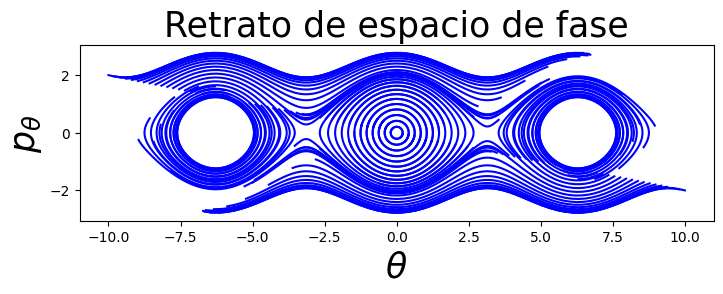

In [14]:
IV = [[5*i, -i] for i in np.linspace(-2, 2, 99)] # valores iniciales
paths = []
for iv in IV:
  t, v = rk4(pendulum, iv[0], iv[1], 0.1, 70)
  paths.append(v)

plot_phase_space_pendulum(paths)

Podemos trazar el espacio de fase del sistema Lotka-Volterra.

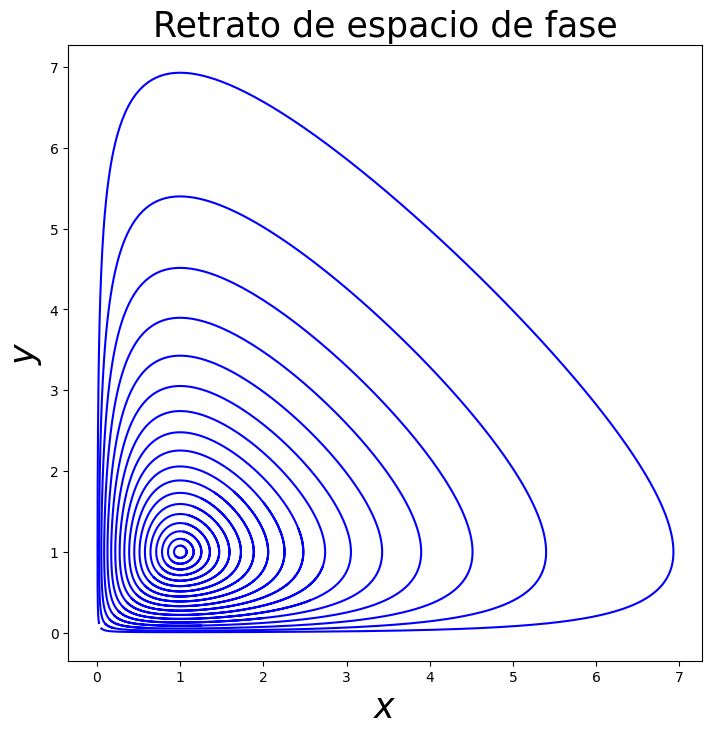

In [15]:
IV = [[i, i] for i in np.linspace(0, 1, 20)] # valores iniciales
paths = []
for iv in IV:
  t, v = rk4(LV, iv[0], iv[1], 0.01, 1000)
  paths.append(v)

plot_phase_space_LV(paths)

## 2. ODEs Neuronales :3

### Introduccion

Dadas las intrigantes propiedades de las EDOs/solvers y la literatura centenaria sobre el tema, parece intrigante combinarlos
con redes neuronales, i.e, intentamos modelar la función de transición con una red neuronal. Esta combinacion podria lelvar a una herramientra poderosa de modelamiento, puesto que redes neuronales son funciones de aproximacion universales &mdash;teoricamente pueden aproximar cualquier funcion diferenciable con una aproximacion arbotraria.

Recordando nuestras definiciones anteriores, tenemos una EDO de primer orden:
$$\mathbf{\dot{y}}(t) = f(t, \mathbf{y}(t), \theta),\quad \mathbf{y}(t_0) = y_0,\quad f: \mathbb{R} \times \mathbb{R}^n \to \mathbb{R}^n $$

Nuestro objetivo es resolver problemas de valor inicial (PVI), i.e. predecir $\mathbf{y}(t_1)$ dado $\mathbf{y}(t_0)$.

$$
\mathbf{y}(t_1) = \mathbf{y}(t_0) + \int_{t_0}^{t_1} f(\mathbf{y}(t), t, \theta)
\mathrm{d}t = \textrm{ODESolve}(\mathbf{y}(t_0), f, t_0, t_1, \theta)
$$

### Comparación con Resnets

Muchas arquitecturas populares de aprendizaje profundo como ResNets$^2$ actualizan estados ocultos empleando conexiones residuales:

$$
  \mathbf{y}_{l+1} = \mathbf{y}_l + f(\mathbf{y}_l, \theta_l)
$$

donde $f$ es una red neuronal con parámetros $\theta_l$, y $\mathbf{y}_l$ y $\mathbf{y}_{l+1}$ son los estados ocultos en las capas subsiguientes, $l \in \{0,\ldots, L\}$.

Estas actualizaciones pueden verse como discretizaciones de Euler de transformaciones continuas.

$$
\begin{align}
\mathbf{\dot{y}} &= f(\mathbf{y}, t, \theta)
\\
&\Bigg\downarrow \ \textrm{Discretizacion de Euler}
\\
\mathbf{y}_{n+1} &= \mathbf{y}_n + h f(\mathbf{y}_n, t_n, \theta)
\end{align}
$$

Volviendo al reino continuo nuevamente, ¿qué sucede en una red residual (con tamaños de paso $h$) si consideramos el límite continuo de cada capa discreta en la red? En otras palabras, ¿qué sucede a medida que agregamos más capas y tomamos
¿pasos? La respuesta parece bastante sorprendente: en lugar de tener un número discreto de capas entre los dominios de entrada y salida, ¡permitimos que la evolución de los estados ocultos se vuelva continua!



### Backpropagation

Ahora tenemos una forma de realizar el pase hacia adelante para nuestro modelo. Sin embargo, ¿cómo retropropagamos y entrenamos la red?

Una forma muy sencilla de realizar backprop es propagar hacia atrás a través del solucionador. Esto funcionaría ya que las operaciones de pase hacia adelante son continuas y diferenciables. El problema, sin embargo, es que esto genera un alto costo de memoria y necesitaríamos guardar todas las activaciones intermedias del solucionador.

Sin embargo, lo que es más importante, nuestro objetivo debe ser tratar de aproximar el
  derivada exacta, en lugar de diferenciar la aproximación.

Queremos optimizar nuestra función de pérdida de valor escalar $L$ con respecto a los parametros del modelo $\theta$.

$$
L(\mathbf{x}(t_1)) = L\left(\mathbf{x}(t_0) + \int_{t_0}^{t_1} f(\mathbf{x}(t), t,
\theta)
\mathrm{d}t\right) = L\left(\textrm{ODESolve}(\mathbf{x}(t_0), f, t_0, t_1, \theta)\right)
$$

Para optimizar $L$ requerimos de los gradientes respecto a $\theta$. 

El problema es calcular eficientemente $\frac{\mathrm{d}L(\mathbf{x}(t_1))}{\mathrm{d}\theta}$ sin almacenar todas las activaciones de funciones del pase hacia adelante.

**Metodo adjunto al rescate**! El método de sensibilidad adjunto fue desarrollado en 1962 por Pontryagin et al. Aprovecha el hecho de que el paso hacia adelante es la solución a una EDO y calcula los gradientes resolviendo una segunda EDO aumentada hacia atrás en el tiempo.

De manera similar a las redes neuronales estándar, comenzamos determinando cómo el gradiente de pérdida depende del estado oculto. Esta cantidad se llama *adjunta* $\mathbf{a}(t) = \frac{\partial L}{\partial \mathbf{x}(t)}$.
Satisface el siguiente PVI:

$$
 \dot{\mathbf{a}}(t) = -\mathbf{a}(t)^{\top} \frac{\partial f(\mathbf{x}(t), t,
\theta)}{\partial \mathbf{x}}, \quad \mathbf{a}(t_1) = \frac{\partial L}{\partial \mathbf{x}(t_1)}.
$$

Por lo tanto, a partir del valor inicial (recuerde que corremos hacia atras) $\mathbf{a}(t_1) = \frac{\partial L}{\partial \mathbf{x}(t_1)}$, podemos calcular $\mathbf{a}(t_0) = \frac{\partial L}{\partial \mathbf{x}(t_0)}$ mediante otra llamadando a un solver de EDOs.

Finalmente, calculamos los gradientes con respecto a los parametros $\theta$ esto requiere evaluar una tercera integral, la cual depende de $\mathbf{x}(t)$ y $\mathbf{a}(t)$:

$$ \frac{\mathrm{d}L}{\mathrm{d}\theta} = -\int_{t_1}^{t_0} \mathbf{a}(t)^{\top}\frac{\partial f}{\partial \theta} \mathrm{d}t,
$$

Entonces, este metodo cambia el calculo por la memoria.

### Time to program some Neural ODEs

In this tutorial we will be working will Half Moons Dataset, a non-linearly separable, binary classification dataset.

Este trabajo esta basado en TorchDyn (https://github.com/DiffEqML/torchdyn), como tambien del original TorchDiffEq examples (https://github.com/rtqichen/torchdiffeq). 

In [16]:
class MoonsDataset(Dataset):
    """Half Moons Classification Dataset
    
    Adaptada de https://github.com/DiffEqML/torchdyn
    """
    def __init__(self, num_samples=100, noise_std=1e-4):
        self.num_samples = num_samples
        self.noise_std = noise_std
        self.X, self.y = self.generate_moons(num_samples, noise_std)

    @staticmethod
    def generate_moons(num_samples=100, noise_std=1e-4):
        """Crea un conjunto de puntos de datos `num_samples`.
        :param num_samples: numero de puntos de datos en la dataset generada
        :type num_samples: int
        :param noise_std: desviacion estandar de la magnitud del ruido anadido a cada punto de la data
        :type noise_std: float
        """
        num_samples_out = num_samples // 2
        num_samples_in = num_samples - num_samples_out
        theta_out = np.linspace(0, np.pi, num_samples_out)
        theta_in = np.linspace(0, np.pi, num_samples_in)
        outer_circ_x = np.cos(theta_out)
        outer_circ_y = np.sin(theta_out)
        inner_circ_x = 1 - np.cos(theta_in)
        inner_circ_y = 1 - np.sin(theta_in) - 0.5

        X = np.vstack([np.append(outer_circ_x, inner_circ_x),
                       np.append(outer_circ_y, inner_circ_y)]).T
        y = np.hstack([np.zeros(num_samples_out), np.ones(num_samples_in)])

        if noise_std is not None:
            X += noise_std * np.random.rand(num_samples, 2)

        X = torch.Tensor(X)
        y = torch.LongTensor(y)
        return X, y

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
def plot_binary_classification_dataset(X, y, title=None):
    CLASS_COLORS = ['coral', 'darkviolet']
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(X[:, 0], X[:, 1], color=[CLASS_COLORS[yi.int()] for yi in y], alpha=0.6)
    ax.set_aspect('equal')
    if title is not None:
        ax.set_title(title)

    return fig, ax

Creemos una dataset de ejemplo y visualicemosla.

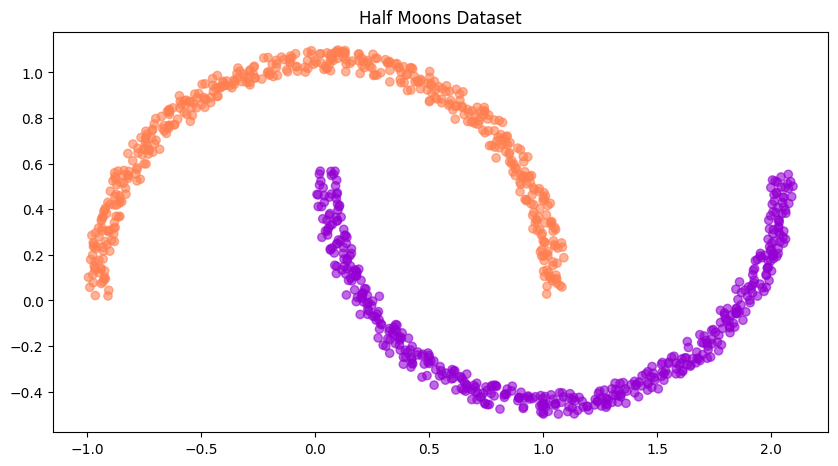

In [18]:
sample_dataset = MoonsDataset(num_samples=1000, noise_std=1e-1)
fig, ax = plot_binary_classification_dataset(sample_dataset.X, sample_dataset.y, title='Half Moons Dataset')

Ahora vamos a crear los conjuntos de entrenamiento, validación y prueba, con sus cargadores de datos correspondientes. Crearemos un solo gran conjunto de datos y lo dividiremos aleatoriamente en conjuntos de entrenamiento, validacion y prueba.

In [19]:
def split_dataset(dataset_size:int, split_percentages:List[float]) -> List[int]:
    split_sizes = [int(pi * dataset_size) for pi in split_percentages]
    split_sizes[0] += dataset_size - sum(split_sizes)
    return split_sizes


class ToyDataModule(pl.LightningDataModule):
    def __init__(self, dataset_size:int, split_percentages:Optional[float]=None):
        super().__init__()
        self.dataset_size = dataset_size
        if split_percentages is None:
            split_percentages = [0.8, 0.1, 0.1]
        self.split_sizes = split_dataset(self.dataset_size, split_percentages)

    def prepare_data(self):
        pass

    def setup(self, stage: Optional[str] = None):
        pass

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(self.train_set, batch_size=len(self.train_set), shuffle=True)
        return train_loader

    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(self.val_set, batch_size=len(self.val_set), shuffle=False)
        return val_loader

    def test_dataloader(self):
        test_loader = torch.utils.data.DataLoader(self.test_set, batch_size=len(self.test_set), shuffle=False)
        return test_loader


class HalfMoonsDataModule(ToyDataModule):
    def __init__(self, dataset_size:int, split_percentages:Optional[float]=None):
        super().__init__(dataset_size, split_percentages=split_percentages)

    def setup(self, stage: Optional[str] = None):
        dataset = MoonsDataset(num_samples=self.dataset_size, noise_std=1e-1)
        self.train_set, self.val_set, self.test_set = torch.utils.data.random_split(dataset, self.split_sizes)

Ahora definimos el nucleo de nuestro modelo Neural ODE.

In [20]:
class _ODEFunc(nn.Module):
    def __init__(self, module, autonomous=True):
        super().__init__()
        self.module = module
        self.autonomous = autonomous

    def forward(self, t, x):
        if not self.autonomous:
            x = torch.cat([torch.ones_like(x[:, [0]]) * t, x], 1)
        return self.module(x)


class ODEBlock(nn.Module):
    def __init__(self, odefunc: nn.Module, solver: str = 'dopri5',
                 rtol: float = 1e-4, atol: float = 1e-4, adjoint: bool = True,
                 autonomous: bool = True):
        super().__init__()
        self.odefunc = _ODEFunc(odefunc, autonomous=autonomous)
        self.rtol = rtol
        self.atol = atol
        self.solver = solver
        self.use_adjoint = adjoint
        self.integration_time = torch.tensor([0, 1], dtype=torch.float32)  
    
    @property
    def ode_method(self):
        return torchdiffeq.odeint_adjoint if self.use_adjoint else torchdiffeq.odeint

    def forward(self, x: torch.Tensor, adjoint: bool = True, integration_time=None):
        integration_time = self.integration_time if integration_time is None else integration_time
        integration_time = integration_time.to(x.device)
        ode_method =  torchdiffeq.odeint_adjoint if adjoint else torchdiffeq.odeint
        out = ode_method(
            self.odefunc, x, integration_time, rtol=self.rtol,
            atol=self.atol, method=self.solver)
        return out

Envolveremos todo junto en un **LightningModule**.

In [21]:
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module, t_span:torch.Tensor, learning_rate:float=5e-3):
        super().__init__()
        self.model = model
        self.t_span = t_span
        self.learning_rate = learning_rate
        self.accuracy = Accuracy(num_classes=2)
    
    def forward(self, x):
        return self.model(x)

    def inference(self, x, time_span):
        return self.model(x, adjoint=False, integration_time=time_span)

    def inference_no_projection(self, x, time_span):
        return self.model.forward_no_projection(x, adjoint=False, integration_time=time_span)
   
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_pred = self(x)
        y_pred = y_pred[-1]  # selecciona el ultimo punto de la trayectoria solucion
        loss = nn.CrossEntropyLoss()(y_pred, y)
        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch      
        y_pred = self(x)
        y_pred = y_pred[-1]  # selecciona el ultimo punto de la trayectoria solucion
        loss = nn.CrossEntropyLoss()(y_pred, y)
        self.log('val_loss', loss, prog_bar=True, logger=True)
        acc = self.accuracy(y_pred.softmax(dim=-1), y)
        self.log('val_accuracy', acc, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch      
        y_pred = self(x)
        y_pred = y_pred[-1]  # selecciona el ultimo punto de la trayectoria solucion
        loss = nn.CrossEntropyLoss()(y_pred, y)
        self.log('test_loss', loss, prog_bar=True, logger=True)
        acc = self.accuracy(y_pred.softmax(dim=-1), y)
        self.log('test_accuracy', acc, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer

Finalmente, es hora de definir una ODE neuronal y entrenarla.
Usaremos un modelo simple de 2 capas con una activación *tanh* y 64 dimensiones ocultas. Entrenaremos el modelo utilizando el método adjunto para backpropagation.

Observacion: IUna nota rapida de la arquitectura de neustro modelo. Como mencionamos en en la primera parte el **teorema Picard-Lindel&ouml;f** (Coddington y Levinson, 1955) establece que la solucion inicial del problema **existe y es unica** si la ecuacion diferencial es _uniformemente Lipschitz continua_ en $\mathbf{z}$ y _continua_ en $t$. Resulta que este teorema se cumple para nuestro modelo si la red neuronal tiene pesos finitos y utiliza no linealidades de Lipshitz, como tanh o relu. Sin embargo, no todas las herramientas de aprendizaje profundo es Lipshitz. Por ejemplo, como se muestra en [**La constante de autoatención de Lipschitz**](https://arxiv.org/abs/2006.04710) de Hyunjik Kim et al., la self-attention estandar es ___no___ Lipshitz. Los autores proponen formas alternativas de self-attention que son Lipshitz.

In [22]:
adjoint = True
data_module = HalfMoonsDataModule(1000)
t_span = torch.linspace(0, 1, 2)
f = nn.Sequential(
    nn.Linear(2, 64),
    nn.Tanh(),
    nn.Linear(64, 2))
model = ODEBlock(f, adjoint=adjoint)
learner = Learner(model, t_span)

trainer = pl.Trainer(
    max_epochs=200,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[
        pl.callbacks.ModelCheckpoint(mode="max", monitor="val_accuracy"),
        pl.callbacks.RichProgressBar(),
    ],
    log_every_n_steps=1,
)
trainer.fit(learner, datamodule=data_module)
val_result = trainer.validate(learner, datamodule=data_module, verbose=True)
test_result = trainer.test(learner, datamodule=data_module, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name     ┃ Type     ┃ Params ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model    │ ODEBlock │    322 │
│ 1 │ accuracy │ Accuracy │      0 │
└───┴──────────┴──────────┴────────┘

Trainable params: 322                                                                                              
Non-trainable params: 0                                                                                            
Total params: 322                                                                                                  
Total estimated model params size (MB): 0

Output()

c:\Users\Det-Pc\anaconda3\envs\pytorch-C-DL\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.p
y:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck.
Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) 
in the `DataLoader` init to improve performance.
  rank_zero_warn(

c:\Users\Det-Pc\anaconda3\envs\pytorch-C-DL\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.p
y:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck.
Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) 
in the `DataLoader` init to improve performance.
  rank_zero_warn(

`Trainer.fit` stopped: `max_epochs=200` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │            1.0            │
│         val_loss          │   0.001994435442611575    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │            1.0            │
│         test_loss         │   0.0021792298648506403   │
└───────────────────────────┴───────────────────────────┘

c:\Users\Det-Pc\anaconda3\envs\pytorch-C-DL\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Parece que en menos de 200 epocas hemos alcanzado una precision de validacion perfecta. Ahora usemos el modelo entrenado para ejecutar la inferencia y visualizar las trayectorias usando un lapso de tiempo denso de 100 pasos de tiempo.

In [24]:
@torch.no_grad()
def run_inference(learner, data_loader, time_span):
    learner.to(device)
    trajectories = []
    classes = []
    time_span = torch.from_numpy(time_span).to(device)
    for data, target in data_loader:
        data = data.to(device)
        traj = learner.inference(data, time_span).cpu().numpy()
        trajectories.append(traj)
        classes.extend(target.numpy())
    trajectories = np.concatenate(trajectories, 1)
    return trajectories, classes

time_span = np.linspace(0.0, 1.0, 100)
trajectories, classes = run_inference(learner, data_module.train_dataloader(), time_span)

colors = ['coral', 'darkviolet']
class_colors = [colors[ci] for ci in classes]

Ahora definiremos algunas funciones para visualizar las trayectorias aprendidas, el espacio de estado y el campo vectorial aprendido.

In [25]:
def plot_trajectories(time_span, trajectories, class_colors):
    fig = plt.figure(figsize=(12,6))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    for i in range(trajectories.shape[1]):
        ax0.plot(time_span, trajectories[:, i, 0], color=class_colors[i], alpha=0.1)
        ax1.plot(time_span, trajectories[:, i, 1], color=class_colors[i], alpha=0.1)

    ax0.set_xlabel(r"$t$ [Depth]")
    ax0.set_ylabel(r"$\mathbf{z}_0(t)$")
    ax0.set_title("Dimension 0")
    ax1.set_xlabel(r"$t$ [Depth]")
    ax1.set_ylabel(r"$\mathbf{z}_1(t)$")
    ax1.set_title("Dimension 1")


def plot_trajectories_3d(time_span, trajectories, class_colors):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(trajectories.shape[1]):
        ax.plot(trajectories[:, i, 0], trajectories[:, i, 1], time_span,
                color=class_colors[i], alpha=0.1)

    ax.set_title('Trayectorias 3D')
    ax.set_xlabel(r"$\mathbf{z}_0(t)$")
    ax.set_ylabel(r"$\mathbf{z}_1(t)$")
    ax.set_zlabel(r"$t$")


def plot_trajectories_animation(time_span, trajectories, colors, classes, lim=10.0):
    def animate_frame(t):
        ax.cla()
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        ax.set_title('Trayectorias')
        ax.set_xlabel(r"$\mathbf{z}_0(t)$")
        ax.set_ylabel(r"$\mathbf{z}_1(t)$")

        zero_classes = np.array(classes) == 0
        one_classes = np.array(classes) == 1

        scatter_zero = ax.plot(
            trajectories[t, zero_classes, 0], trajectories[t, zero_classes, 1],
            'o', color=colors[0], alpha=0.2+0.8*t/len(time_span))
        scatter_one = ax.plot(
            trajectories[t, one_classes, 0], trajectories[t, one_classes, 1],
            'o', color=colors[1], alpha=0.2+0.8*t/len(time_span))
        return scatter_zero, scatter_one

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    anim = FuncAnimation(fig, animate_frame, frames=len(time_span))
    plt.close(fig)
    return anim


def plot_augmented_trajectories_animation(time_span, trajectories, colors, classes, lim=10.0):
    def animate_frame(t):
        ax.cla()
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        ax.set_zlim(-lim, lim)
        ax.set_title('Trayectorias')
        ax.set_xlabel(r"$\mathbf{z}_0(t)$")
        ax.set_ylabel(r"$\mathbf{z}_1(t)$")
        ax.set_zlabel(r"$\mathbf{z}_2(t)$")

        zero_classes = np.array(classes) == 0
        one_classes = np.array(classes) == 1

        scatter_zero = ax.plot(
            trajectories[t, zero_classes, 0], trajectories[t, zero_classes, 1], trajectories[t, zero_classes, 2],
            'o', color=colors[0], alpha=0.2+0.8*t/len(time_span))
        scatter_one = ax.plot(
            trajectories[t, one_classes, 0], trajectories[t, one_classes, 1], trajectories[t, one_classes, 2],
            'o', color=colors[1], alpha=0.2+0.8*t/len(time_span))
        return scatter_zero, scatter_one

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    anim = FuncAnimation(fig, animate_frame, frames=len(time_span))
    plt.close(fig)
    return anim


def plot_state_space(trajectories, class_colors, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)

    for i in range(trajectories.shape[1]):
        ax.plot(trajectories[:, i, 0], trajectories[:, i, 1],
                color=class_colors[i], alpha=0.1)

    ax.set_title('Diagrama de Espacio de Estado')
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")


def plot_augmented_state_space(trajectories, class_colors, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')

    for i in range(trajectories.shape[1]):
        ax.plot(trajectories[:, i, 0], trajectories[:, i, 1], trajectories[:, i, 2],
                color=class_colors[i], alpha=0.1)

    ax.set_title('Diagrama de Espacio de Estado')
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_zlabel(r"$z$")


def plot_static_vector_field(model, trajectory, N=50, device='gpu', ax=None):
    X, Y = np.mgrid[trajectory[..., 0].min():trajectory[..., 0].max():N*1j,
                    trajectory[..., 1].min():trajectory[..., 1].max():N*1j]
    X = X.T
    Y = Y.T
    P = np.vstack([X.ravel(), Y.ravel()]).T
    P = torch.Tensor(P).to(device)

    with torch.no_grad():
        vector_field = model.odefunc(0.0, P).cpu()
    vector_norm = vector_field.norm(dim=1).view(N, N).numpy()

    vector_field = vector_field.view(N, N, 2).numpy()

    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
    ax.contourf(X, Y, vector_norm, cmap='RdYlBu')
    ax.streamplot(X, Y, vector_field[:, :, 0], vector_field[:, :, 1], color='k')

    ax.set_xlim([X.min(), X.max()])
    ax.set_ylim([Y.min(), Y.max()])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_title("Campo Vectorial Aprendido")

Antes de visualizar las trayectorias, tracemos los datos (de entrenamiento) una vez mas:

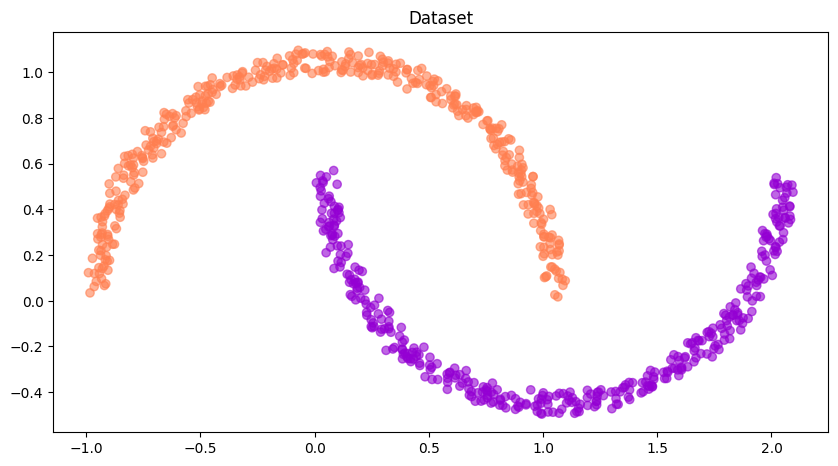

In [26]:
fig, ax = plot_binary_classification_dataset(*data_module.train_set[:], title='Dataset')

A continuación visualizamos la evolución de cada una de las 2 dimensiones de entrada en función del tiempo (profundidad):

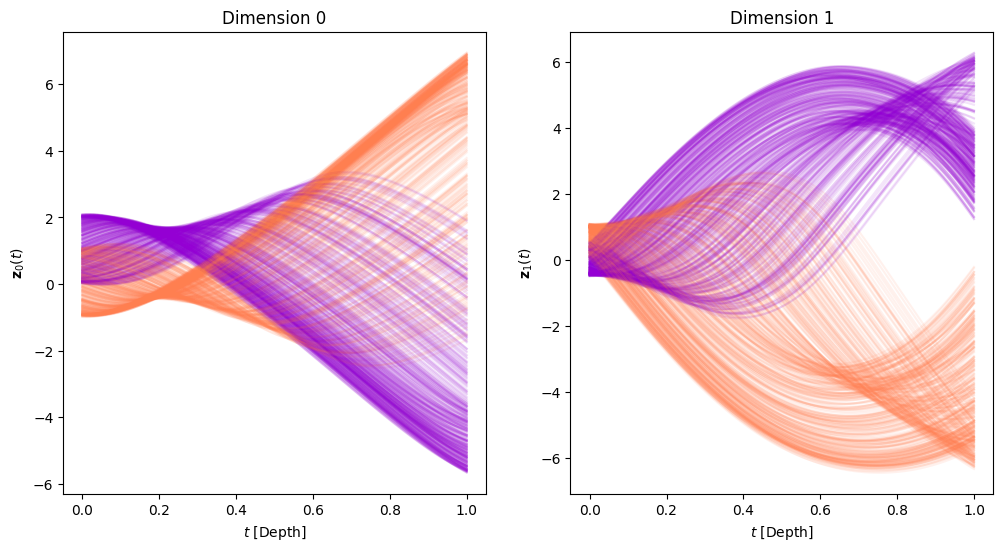

In [27]:
plot_trajectories(time_span, trajectories, class_colors)

Y la misma evolucion combinada en una sola trama:

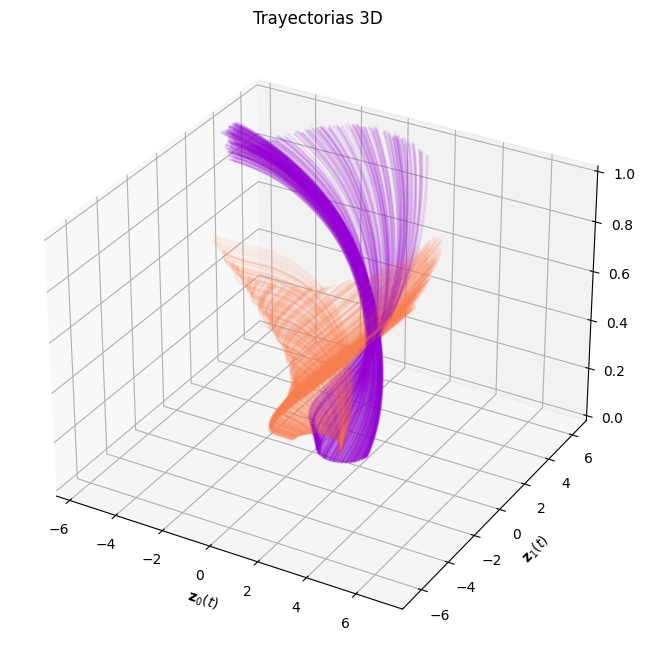

In [28]:
plot_trajectories_3d(time_span, trajectories, class_colors)

La trama 3D puede ser algo complicada de descifrar. Por lo tanto, tambien trazamos una version animada de la evolución. Cada paso de tiempo de la animación es un corte en el eje temporal de la figura de arriba.

In [29]:
anim = plot_trajectories_animation(time_span, trajectories, colors, classes, lim=8.0)
HTML(anim.to_html5_video())

Finalmente, visualicemos el diagrama de espacio de estado y el campo vectorial aprendido:

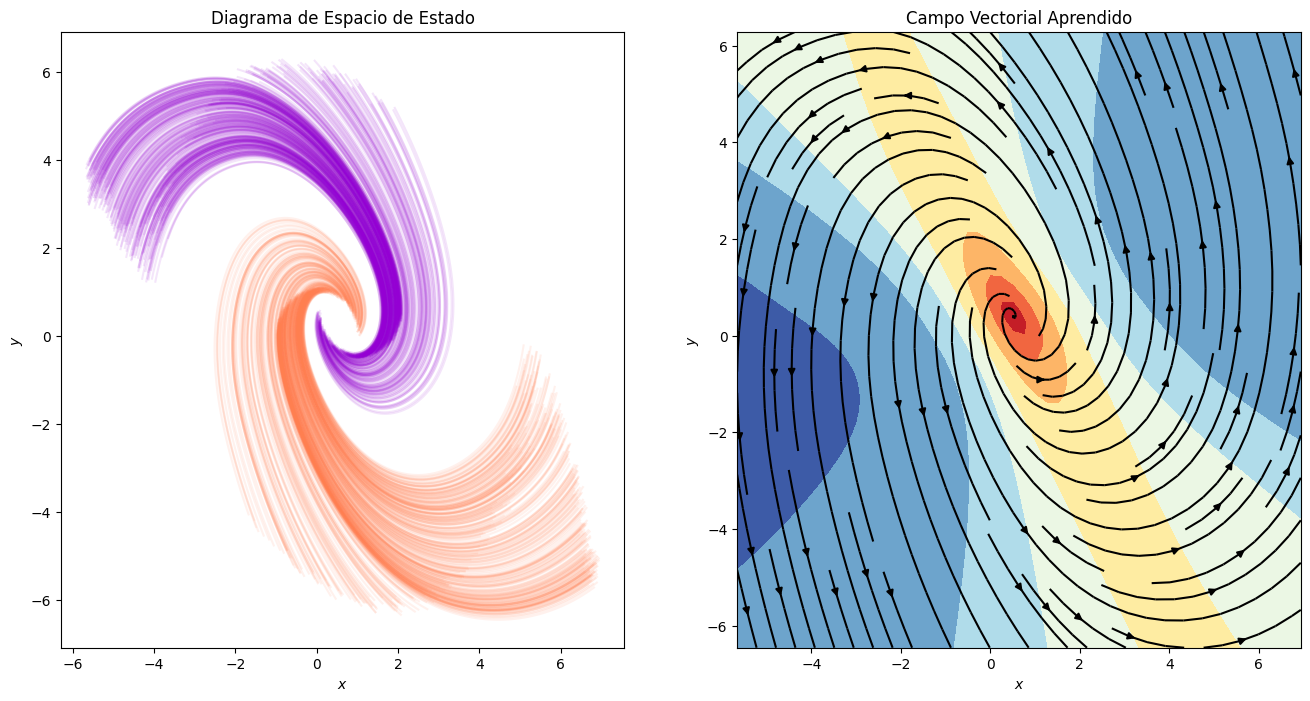

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
plot_state_space(trajectories, class_colors, ax=ax[0])
plot_static_vector_field(model, trajectories, ax=ax[1], device=device)

### Neural EDOs solo pueden describir homeomorfismos

Parece que la red puede hacer un muy buen trabajo separando los datos de estas 2 clases. Ahora pasaremos a una configuración diferente, que parece similar al principio en términos de dificultad, pero resultará ser muy difícil, incluso teóricamente imposible de resolver para las EDOs neuronales en su forma básica.

Las EDOs neuronales describen homeomorfismos (flujos). Las entradas/estados ocultos/salidas tienen la misma dimensionalidad. Forman trayectorias que no se cruzan.

Dado que las EDOs neuronales no pueden modelar no homeomorfismos, no pueden, por ejemplo, separar un conjunto de datos de circulos/anillos concentricos 2d.

$$ 0 < r_1 < r_2 < r_3, \quad g: \mathbb{R}^2 \to \mathbb{R} $$

$$
\begin{cases}
  g(\mathbf{x}) = 0, & \lVert \mathbf{x}\rVert \leq r_1,\\
  g(\mathbf{x}) = 1, & r_2 \leq \lVert \mathbf{x}\rVert \leq r_3
\end{cases}
$$


(Esto se lo peude ver aqui. [Emilien Dupont et al.](https://arxiv.org/abs/1904.01681))

Las EDO neuronales (NODEs) no pueden representar esa función, las características de los NODEs conservan la topología del espacio de entrada.
Los NODEs solo pueden deformar continuamente el espacio de entrada y no pueden, por
ejemplo, rasgar una región conectada aparte.

En la práctica, sin embargo, las EDOs neuronales no se entrenan en regiones continuas del espacio, sino que se entrenan en un número finito de puntos de datos. Esto significa que las NODEs pueden "hacer trampa" y estirar el espacio, abriéndose paso entre los espacios entre los puntos de datos. Esto puede conducir a problemas de EDOs mal planteadas que son numéricamente costosas de resolver.

Veamos este efecto en la practica. Primero, definiremos un conjunto de datos similar que comprende 2 círculos concéntricos 2D.

In [31]:
def rand_sphere(num_samples:int, dim:int, radius:float) -> torch.Tensor:
    """Ejemplo uniforme de una esfera `dim`-dimensional de radio `radius`
    :param num_samples: numero de puntos del ejemplo
    :type num_samples: int
    :param dim: dimension de la hyper-esfera
    :type dim: int
    :param radius: radio de la hyper-esfera
    :type radius: float
    """
    v = torch.randn(num_samples, dim)
    points = radius * F.normalize(v, dim=-1)
    return points


class ConcentricCircles(Dataset):
    """DAtaset de clasificación de círculos concentricos
    
    Adaptada de https://github.com/DiffEqML/torchdyn
    """
    def __init__(self, num_samples=100, noise_std=1e-4, inner_radius=0.5,
                 outer_radius=1.0):
        self.num_samples = num_samples
        self.noise_std = noise_std
        self.X, self.y = self.generate_concentric_circles(num_samples, noise_std)

    @staticmethod
    def generate_concentric_circles(num_samples:int=100, noise_std:float=1e-4,
                                    inner_radius:float=0.5, outer_radius:int=1.0):
        """Crea un dataset de *circulos concentricos* de `num_samples` puntos de ejemplo.
        :param num_samples: numero de puntos en la dataset generada
        :type num_samples: int
        :param noise_std: desviacion estandar de la magnitud de ruidoanadido a cada punto de la dataset
        :type noise_std: float
        :param inner_radius: radio del circulo interno
        :type inner_radius: float
        :param outer_radius: radio del circulo externo
        :type outer_radius: float
        """
        y = torch.zeros(num_samples, dtype=torch.long)
        y[:num_samples // 2] = 1

        X = torch.zeros((num_samples, 2))
        X[:num_samples // 2] = rand_sphere(num_samples // 2, 2, inner_radius)
        X[num_samples // 2:] = rand_sphere(num_samples - num_samples // 2, 2, outer_radius)
        X += noise_std * torch.randn((num_samples, 2))

        return X, y

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ConcentricCirclesDataModule(ToyDataModule):
    def __init__(self, dataset_size:int, split_percentages:Optional[float]=None):
        super().__init__(dataset_size, split_percentages=split_percentages)
    
    def setup(self, stage: Optional[str] = None):
        dataset = ConcentricCircles(num_samples=self.dataset_size, noise_std=5e-2)
        self.train_set, self.val_set, self.test_set = torch.utils.data.random_split(dataset, self.split_sizes)

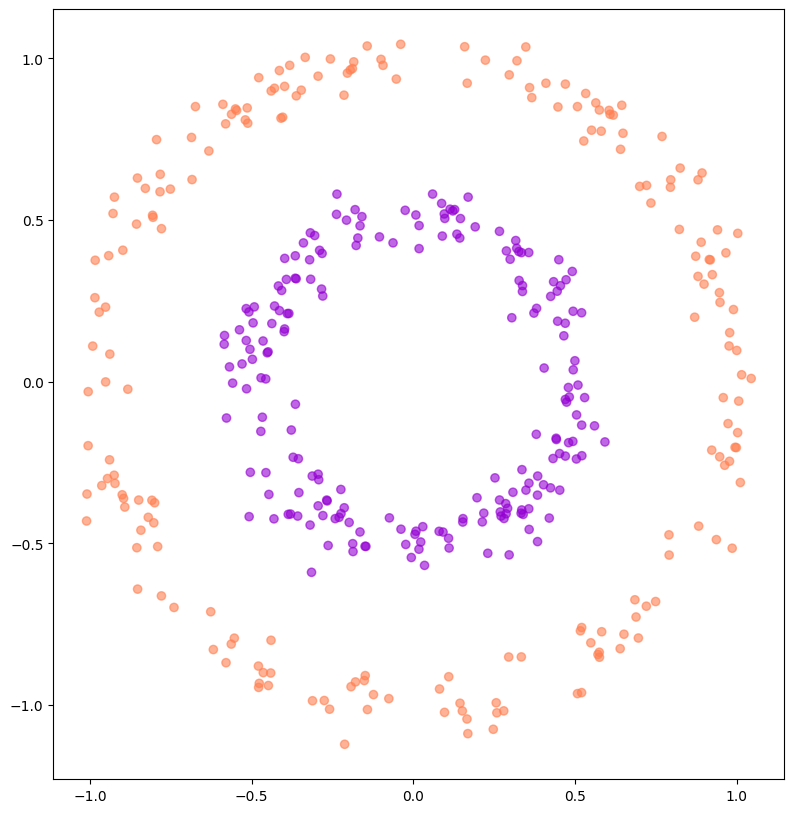

In [32]:
sample_circles_set = ConcentricCircles(num_samples=401, noise_std=5e-2)
fig, ax = plot_binary_classification_dataset(*sample_circles_set[:])

Ahora entrenaremos una EDO neuronal (NODE) en este conjunto de datos. Usaremos 3 capas con activaciones ReLU y 64 dimensiones ocultas.

In [33]:
circles_data_module = ConcentricCirclesDataModule(1000)

adjoint = True
t_span = torch.linspace(0, 1, 2)
f = nn.Sequential(nn.Linear(2, 64),
                    nn.Tanh(),
                    nn.Linear(64, 64),
                    nn.Tanh(),
                    nn.Linear(64, 2))
model = ODEBlock(f, adjoint=adjoint)
learner = Learner(model, t_span)

trainer = pl.Trainer(
    max_epochs=300,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[
        pl.callbacks.ModelCheckpoint(mode="max", monitor="val_accuracy"),
        pl.callbacks.RichProgressBar(),
    ],
    log_every_n_steps=1,
)

trainer.fit(learner, datamodule=circles_data_module)
val_result = trainer.validate(learner, datamodule=circles_data_module, verbose=True)
test_result = trainer.test(learner, datamodule=circles_data_module, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name     ┃ Type     ┃ Params ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model    │ ODEBlock │  4.5 K │
│ 1 │ accuracy │ Accuracy │      0 │
└───┴──────────┴──────────┴────────┘

Trainable params: 4.5 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.5 K                                                                                                
Total estimated model params size (MB): 0

Output()

c:\Users\Det-Pc\anaconda3\envs\pytorch-C-DL\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.p
y:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck.
Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) 
in the `DataLoader` init to improve performance.
  rank_zero_warn(

c:\Users\Det-Pc\anaconda3\envs\pytorch-C-DL\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.p
y:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck.
Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) 
in the `DataLoader` init to improve performance.
  rank_zero_warn(

`Trainer.fit` stopped: `max_epochs=300` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.9700000286102295     │
│         val_loss          │    0.08590108156204224    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9399999976158142     │
│         test_loss         │    0.1400013267993927     │
└───────────────────────────┴───────────────────────────┘

c:\Users\Det-Pc\anaconda3\envs\pytorch-C-DL\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Curiosamente, el modelo puede lograr una precisión perfecta, aunque en teoría no puede separar las 2 clases.

Visualicemos las trayectorias y veamos como puede ser este el caso. Similar al experimento anterior, primero ejecutaremos la inferencia y guardaremos las trayectorias utilizando un lapso de tiempo denso.

In [34]:
num_timesteps = 100
time_span = np.linspace(0.0, 1.0, num_timesteps)
trajectories, classes = run_inference(learner, circles_data_module.train_dataloader(), time_span)

colors = ['coral', 'darkviolet']
class_colors = [colors[ci] for ci in classes]

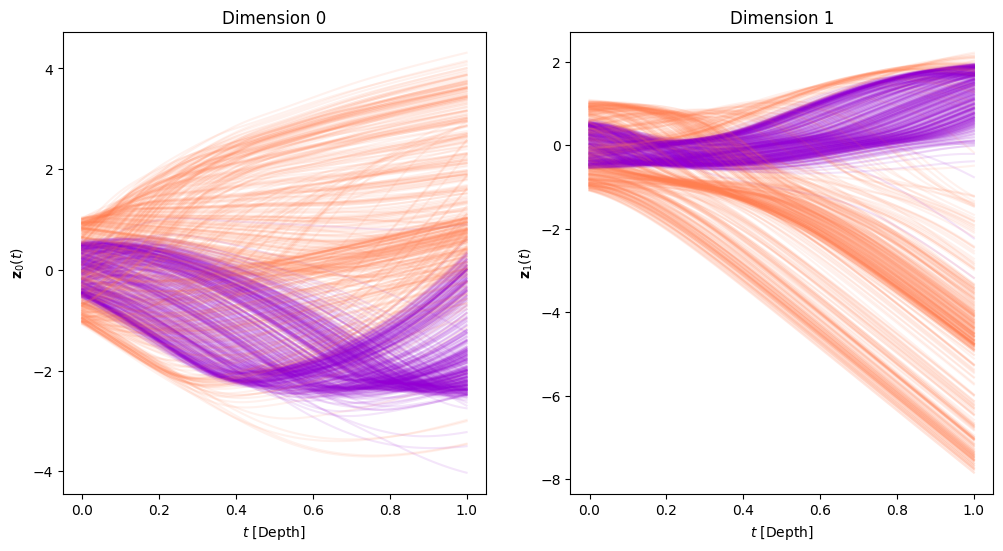

In [35]:
plot_trajectories(time_span, trajectories, class_colors)

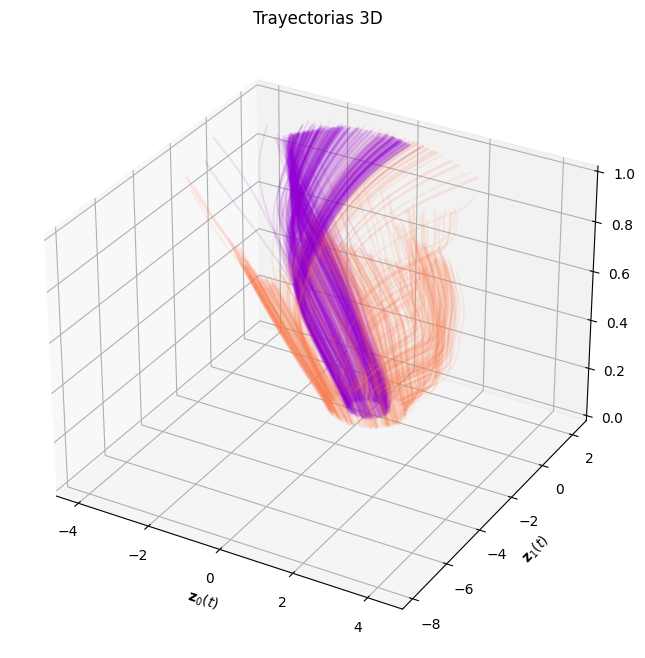

In [36]:
plot_trajectories_3d(time_span, trajectories, class_colors)

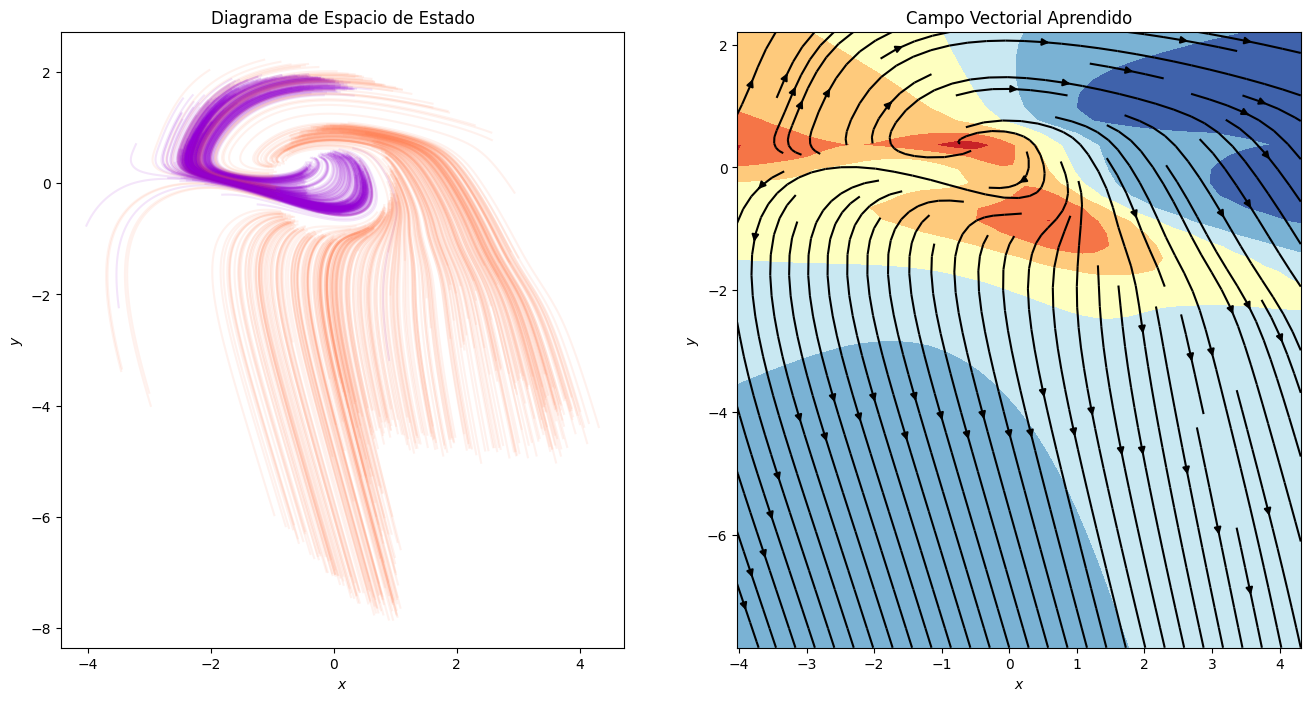

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
plot_state_space(trajectories, class_colors, ax=ax[0])
plot_static_vector_field(model, trajectories, ax=ax[1], device=device)

No queda claro ni a partir de las trayectorias, ni del espacio de estados, como el modelo logra separar los datos. Usemos una visualización animada de la evolucion una vez mas.

In [38]:
anim = plot_trajectories_animation(time_span, trajectories, colors, classes, lim=12.0)
HTML(anim.to_html5_video())

La animación muestra claramente que el modelo esta haciendo trampa al estirar tanto una parte del espacio que los puntos de datos del círculo interior pueden fluir en esa region. Si bien esto ofrece una precisión perfecta en este conjunto de datos, se produce a expensas de las capacidades de generalizacion y de un mayor tiempo de entrenamiento e inferencia, ya que la red tiene que ejecutar muchas mas evaluaciones de funciones para lograr estos resultados.

### Neural EDOs Aumentadas

Los autores de [**Augmented Neural ODEs**](https://arxiv.org/abs/1904.01681) propusieron una solucion simple pero elegante al rpoblema anteriormente visto. Ellxs aumentaron el espacio en el cual aprende y resuelve la EDO, de $\mathbb{R}^d$ a $\mathbb{R}^{d+p}$.

El estado inicial $\mathbf{x}$ se aumenta con $\mathbf{a}$ dimensiones adicionales que son iicializadas con 0.

La EDO aumentada es formulada como:
$$
\begin{bmatrix}
\mathbf{\dot{h}}(t)
\\
\mathbf{\dot{a}}(t)
\end{bmatrix}
=
\mathbf{f}
\left(
\begin{bmatrix}
\mathbf{\dot{h}}(t)
\\
\mathbf{\dot{a}}(t)
\end{bmatrix}    
\right),
\ \ \ 
\begin{bmatrix}
\mathbf{h}(0)
\\
\mathbf{a}(0)
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{x}
\\
\mathbf{0}
\end{bmatrix}   
$$

Las predicciones finales en el espacio original se logran a través de una red final que transforma los estados aumentados de salida:

$$
\mathbf{\hat{y}} =
\mathbf{g}
\left(
\begin{bmatrix}
\mathbf{h}(T)
\\
\mathbf{a}(T)
\end{bmatrix}
\right),
$$

donde $\mathbf{g}$ puede ser un *MLP* o incluso una simple capa *linear*.

Ahora definiremos un modulo aumentador simple y un contenedor NODE que incorpora el aumentador y la red de salida.

In [39]:
class ZeroAugmenter(nn.Module):
    def __init__(self, axis=1, num_dims=1):
        super().__init__()
        self.axis = axis
        self.num_dims = num_dims
    
    def forward(self, x):
        aug_dims = list(x.shape)
        aug_dims[self.axis] = self.num_dims
        augmentation = torch.zeros(aug_dims, device=x.device, dtype=x.dtype)
        return torch.cat([x, augmentation], dim=self.axis)


class AugmentedNODEWrapper(nn.Module):
    def __init__(self, augmenter, neural_ode, out_net):
        super().__init__()
        self.augmenter = augmenter
        self.neural_ode = neural_ode
        self.out_net = out_net
    
    def forward(self, x: torch.Tensor, adjoint: bool = True, integration_time=None):
        x = self.augmenter(x)
        x = self.neural_ode(x, adjoint, integration_time)
        x = self.out_net(x)
        return x
    
    def forward_no_projection(self, x: torch.Tensor, adjoint: bool = True, integration_time=None):
        x = self.augmenter(x)
        x = self.neural_ode(x, adjoint, integration_time)
        return x

Continuaremos con el mismo conjunto de datos que antes, i.e., los circulos concentricos 2D. Usaremos una sola dimensión de aumento y una capa lineal simple $\mathbf{g}: \mathbb{R}^3 \to \mathbb{R}^2$.

In [40]:
circles_data_module = ConcentricCirclesDataModule(1000)

adjoint = True
t_span = torch.linspace(0, 1, 2)
augmentation_dims = 1
f = nn.Sequential(nn.Linear(2+augmentation_dims, 64),
                    nn.Tanh(),
                    nn.Linear(64, 2+augmentation_dims))
no_augm_model = ODEBlock(f, adjoint=adjoint)
model = AugmentedNODEWrapper(ZeroAugmenter(num_dims=augmentation_dims), no_augm_model, nn.Linear(2+augmentation_dims, 2))
learner = Learner(model, t_span)

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[
        pl.callbacks.ModelCheckpoint(mode="max", monitor="val_accuracy"),
        pl.callbacks.RichProgressBar(),
    ],
    log_every_n_steps=1,
)

trainer.fit(learner, datamodule=circles_data_module)
val_result = trainer.validate(learner, datamodule=circles_data_module, verbose=True)
test_result = trainer.test(learner, datamodule=circles_data_module, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name     ┃ Type                 ┃ Params ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model    │ AugmentedNODEWrapper │    459 │
│ 1 │ accuracy │ Accuracy             │      0 │
└───┴──────────┴──────────────────────┴────────┘

Trainable params: 459                                                                                              
Non-trainable params: 0                                                                                            
Total params: 459                                                                                                  
Total estimated model params size (MB): 0

Output()

c:\Users\Det-Pc\anaconda3\envs\pytorch-C-DL\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.p
y:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck.
Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) 
in the `DataLoader` init to improve performance.
  rank_zero_warn(

c:\Users\Det-Pc\anaconda3\envs\pytorch-C-DL\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.p
y:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck.
Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) 
in the `DataLoader` init to improve performance.
  rank_zero_warn(

`Trainer.fit` stopped: `max_epochs=100` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │            1.0            │
│         val_loss          │   7.260608072101604e-06   │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │            1.0            │
│         test_loss         │   5.69325675314758e-06    │
└───────────────────────────┴───────────────────────────┘

c:\Users\Det-Pc\anaconda3\envs\pytorch-C-DL\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Incluso con una sola dimension de aumento, el modelo puede lograr muy rapidamente una precision perfecta en el conjunto de validacion. Ahora calculemos y visualicemos las trayectorias, para obtener una mejor comprension de lo que realmente esta sucediendo.

In [41]:
num_timesteps = 100
time_span = np.linspace(0.0, 1.0, num_timesteps)
trajectories, classes = run_inference(learner, circles_data_module.train_dataloader(), time_span)

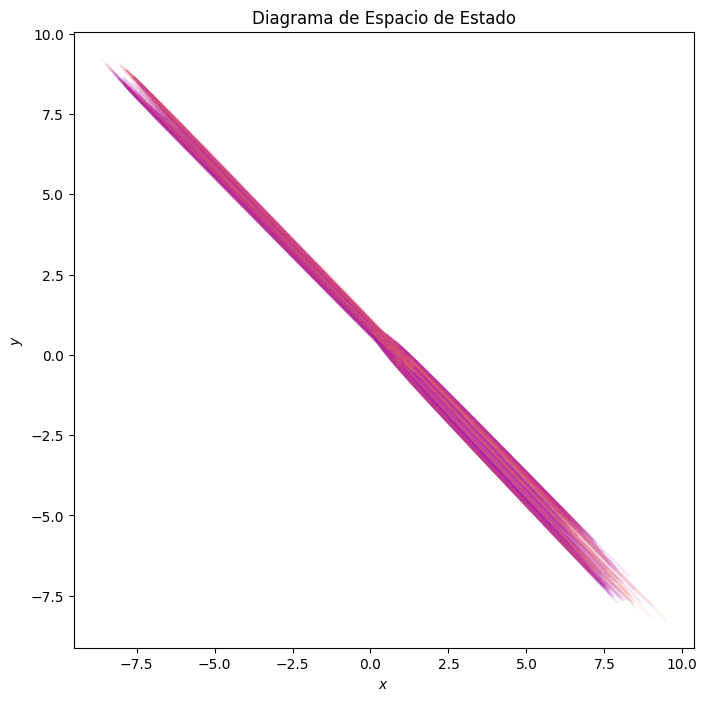

In [42]:
plot_state_space(trajectories, class_colors)

In [43]:
anim = plot_trajectories_animation(time_span, trajectories, colors, classes, lim=8.0)
HTML(anim.to_html5_video())

A partir de los graficos 2D, no esta exactamente claro como el modelo puede lograr una separacion perfecta. Por lo tanto, en lo que sigue, visualizaremos las trayectorias y el espacio de estado en el espacio 3D aumentado.

In [44]:
@torch.no_grad()
def run_inference_no_projection(learner, data_loader, time_span):
    trajectories = []
    classes = []
    learner = learner.to(device)
    time_span = torch.from_numpy(time_span).to(device)
    for data, target in data_loader:
        data = data.to(device)
        traj = learner.inference_no_projection(data, time_span).cpu().numpy()
        trajectories.append(traj)
        classes.extend(target.numpy())
    trajectories = np.concatenate(trajectories, 1)
    return trajectories, classes

num_timesteps = 100
time_span = np.linspace(0.0, 1.0, num_timesteps)
trajectories, classes = run_inference_no_projection(learner, circles_data_module.train_dataloader(), time_span)
colors = ['coral', 'darkviolet']
class_colors = [colors[ci] for ci in classes]

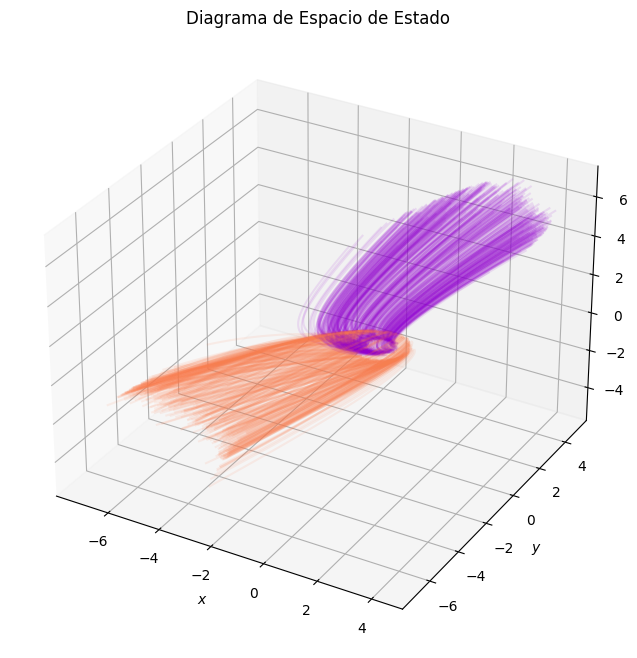

In [45]:
plot_augmented_state_space(trajectories, class_colors)

In [46]:
anim = plot_augmented_trajectories_animation(time_span, trajectories, colors, classes, lim=8.0)
HTML(anim.to_html5_video())